# Measuring Volatility Using the ARCH Model

ARCH models are a popular class of volatility models that use observed values of returns or residuals as volatility shocks. A basic GARCH (1,1) model is specified as

$$
\begin{aligned}
r_t &= \mu + \epsilon_t\\
\epsilon_t &= \sigma_t e_t\\
\sigma^2_t &= \omega + \alpha \epsilon_{t-1}^2 + \beta \sigma^2_{t-1}
\end{aligned}
$$

A complete ARCH model is divided into three components:
- a mean model, e.g., a constant mean or an ARX;
- a volatility process, e.g., a GARCH or an EGARCH process; and
- a distribution for the standardized residuals.

While models can be carefully specified using the individual components, most common specifications can be specified using a simple model constructor.

In [1]:
import matplotlib.pyplot as plt
import datetime as dt

# Plotting options
import seaborn
seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

from arch import arch_model
help(arch_model)

Help on function arch_model in module arch.univariate.mean:

arch_model(y: Union[numpy.ndarray, pandas.core.frame.DataFrame, pandas.core.series.Series, NoneType], x: Union[numpy.ndarray, pandas.core.frame.DataFrame, NoneType] = None, mean: Literal['Constant', 'Zero', 'LS', 'AR', 'ARX', 'HAR', 'HARX', 'constant', 'zero'] = 'Constant', lags: Union[int, list[int], numpy.ndarray[Any, numpy.dtype[numpy.intc]], numpy.ndarray[Any, numpy.dtype[numpy.int64]], NoneType] = 0, vol: Literal['GARCH', 'ARCH', 'EGARCH', 'FIGARCH', 'APARCH', 'HARCH'] = 'GARCH', p: Union[int, list[int]] = 1, o: int = 0, q: int = 1, power: float = 2.0, dist: Literal['normal', 'gaussian', 't', 'studentst', 'skewstudent', 'skewt', 'ged', 'generalized error'] = 'normal', hold_back: Optional[int] = None, rescale: Optional[bool] = None) -> arch.univariate.mean.HARX
    Initialization of common ARCH model specifications

    Parameters
    ----------
    y : ndarray, Series, None
        The dependent variable
    x : ndarray,

In [2]:
import datetime as dt
import pandas_datareader.data as web
djia = web.get_data_fred('DJIA')
returns = 100 * djia['DJIA'].pct_change(fill_method=None).dropna()

# A basic GARCH(1,1) with a constant mean can be constructed using only the return data

from arch.univariate import arch_model
am = arch_model(returns)
res = am.fit()
print(res.summary())
# Alternative mean and volatility processes can be directly specified

am = arch_model(returns, mean='AR', lags=2, vol='harch', p=[1, 5, 22])
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6836.13339682199
Iteration:      2,   Func. Count:     16,   Neg. LLF: 20804043377.68502
Iteration:      3,   Func. Count:     24,   Neg. LLF: 2790.0771439125856
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2085.6048800526905
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1632.8388640945043
Iteration:      6,   Func. Count:     43,   Neg. LLF: 1635.026716544109
Iteration:      7,   Func. Count:     49,   Neg. LLF: 1631.1097242077158
Iteration:      8,   Func. Count:     54,   Neg. LLF: 1631.1073106637077
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1631.1073038811478
Iteration:     10,   Func. Count:     63,   Neg. LLF: 1631.1073038805976
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1631.1073038811478
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10
                     Constant Mean - GARCH Model Results        

## Testing, Estimating and Forecasting

### Testing for ARCH Effects

A **Lagrange multiplier (LM) test** is often used to test for the presence of **ARCH** effects. To perform the LM test, we first estimate the **mean equation**, which can be a regression of the variable on a constant or may include other variables as well. Then, we save the estimated residuals \( $\hat{e}_t$ \) and obtain their squares \( $\hat{e}_t^2$ \).

To test for the first-order ARCH, we regress \( $\hat{e}_t^2$ \) on the **squared residuals lagged** \( $\hat{e}_{t-1}^2$ \) as follows:

$$
\hat{e}_t^2 = \gamma_0 + \gamma_1 \hat{e}_{t-1}^2 + v_t \tag{1.3}
$$

where \( $v_t$ \) is a random error term. The null and alternative hypotheses are:

$$
H_0: \gamma_1 = 0 \quad \text{vs.} \quad H_1: \gamma_1 \neq 0
$$

If there are no **ARCH** effects, then \( $\gamma_1 = 0$ \) and the fit of (1.3) will be poor, resulting in a low \( $R^2$ \). If **ARCH** effects are present, we expect the magnitude of \( $\hat{e}_t^2$ \) to depend on its lagged values, leading to a relatively high \( $R^2$ \).

The **LM test** statistic is $TR^2$ where $T$ is the sample size.

The test statistic follows a chi-squared distribution:

$$
TR^2 \sim \chi^2_q
$$

where \( $q $\) is the order of lag, and \( $T$ \) is the number of complete observations.

In this case if:

$$
TR^2 \geq \chi^2_{q}
$$

then we reject the null hypothesis that \( $\gamma_1 = 0$ \) and conclude that **ARCH** effects are present.
``


### An Example
For our example, let us examine the stock returns of a fictitous company called “Bring Your Day Lighting” (BYD). Let’s first load the data set and plot the returns against time.

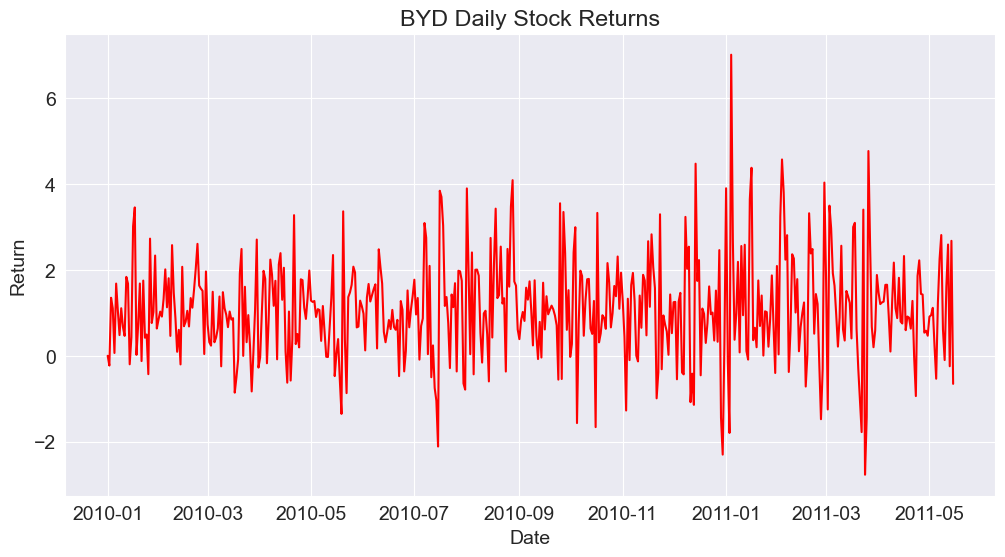

In [79]:
import pandas as pd
# Load the dataset into a pandas DataFrame
df = pd.read_stata('byd.dta')

# Create date range starting from 2010-01-01
df['date'] = pd.date_range(start='2010-01-01', periods=len(df), freq='D')

# Plot using seaborn/matplotlib
plt.figure(figsize=(12,6))
seaborn.lineplot(x='date', y='r', data=df, color='red')
plt.title('BYD Daily Stock Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.show()

To perform the test for ARCH effects, we must:

- Estimate a mean equation that, in this example, is $r_t=\beta_0+ e_t$
- Retrieve the estimated residuals e^t
- Estimate (1.3).

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
import numpy as np

# Assuming 'df' contains the BYD data and 'r' is the return column
# Adding a constant term allows the OLS regression to estimate the mean return
# Step 1: Estimate mean equation r = beta + error
# In this specific case, the only predictor is a constant (no explanatory variables), 
# so the regression is equivalent to calculating the sample mean.
mean_model = sm.OLS(df['r'], np.ones(len(df))).fit()

# Step 2: Retrieve the residuals from the former model and square them
residuals = mean_model.resid
ehatsq = residuals ** 2

# Step 3: Regress squared residuals on one-lagged squared residuals
# Create lagged squared residuals
lagged_ehatsq = lagmat(ehatsq, maxlag=1, trim='both')  # Lagging by 1
ehatsq_trimmed = ehatsq[1:]  # Remove first observation due to lag

# Prepare regression
X_arch = sm.add_constant(lagged_ehatsq)  # Add constant
model = sm.OLS(ehatsq_trimmed, X_arch).fit()

# Display results
print("Mean Equation Results:")
print(mean_model.summary())

print("\nARCH(1) Test Results:")
print(model.summary())
print('LM Test: ', model.rsquared * (len(df['r'])-1))

from statsmodels.stats.diagnostic import het_arch

# Perform ARCH LM Test directly
arch_test = het_arch(residuals, nlags=1)
print(f"LM Test Statistic: {arch_test[0]:.4f}, p-value: {arch_test[1]:.4f}") # LM=(T−q)R^2

Mean Equation Results:
                            OLS Regression Results                            
Dep. Variable:                      r   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 20 Feb 2025   Prob (F-statistic):                nan
Time:                        11:01:05   Log-Likelihood:                -793.85
No. Observations:                 500   AIC:                             1590.
Df Residuals:                     499   BIC:                             1594.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0783      0.

c:\Users\valte\Dropbox (Personal)\Valter Nóbrega\Projects\Immigration, Inequality and Welfare - A Skill-Distribution Perspective\Code\Python Code\.venv\Lib\site-packages\statsmodels\tsa\tsatools.py:162: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  x = pd.concat(x[::order], axis=1)


We can estimate an ARCH(1) model using **arch** package in Python. ARCH models are estiamted using the maximum likelihood method.

In [22]:
from arch import arch_model

# Fit the ARCH model
am = arch_model(df['r'], vol='ARCH')
arch_result = am.fit()

# Display the summary
print(arch_result.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1829.9467953686626
Iteration:      2,   Func. Count:     12,   Neg. LLF: 971.7896515004638
Iteration:      3,   Func. Count:     19,   Neg. LLF: 749.2009500556928
Iteration:      4,   Func. Count:     25,   Neg. LLF: 740.7799802830781
Iteration:      5,   Func. Count:     28,   Neg. LLF: 740.7799802831372
Optimization terminated successfully    (Exit mode 0)
            Current function value: 740.7799802830781
            Iterations: 5
            Function evaluations: 28
            Gradient evaluations: 5
                      Constant Mean - ARCH Model Results                      
Dep. Variable:                      r   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -740.780
Distribution:                  Normal   AIC:                           1487.56
Method:            Maximum Likelihood

Based on the output, the estimated mean of the series is
$$
\hat{r}_t = \hat{\beta}_0 = 1.066
$$

$$
\hat{h}_t = \hat{\alpha}_0 + \hat{\alpha}_1 \hat{\epsilon}_{t-1}^2 = 0.642 + 0.569
$$

Plotting the conditional variance looks something like:

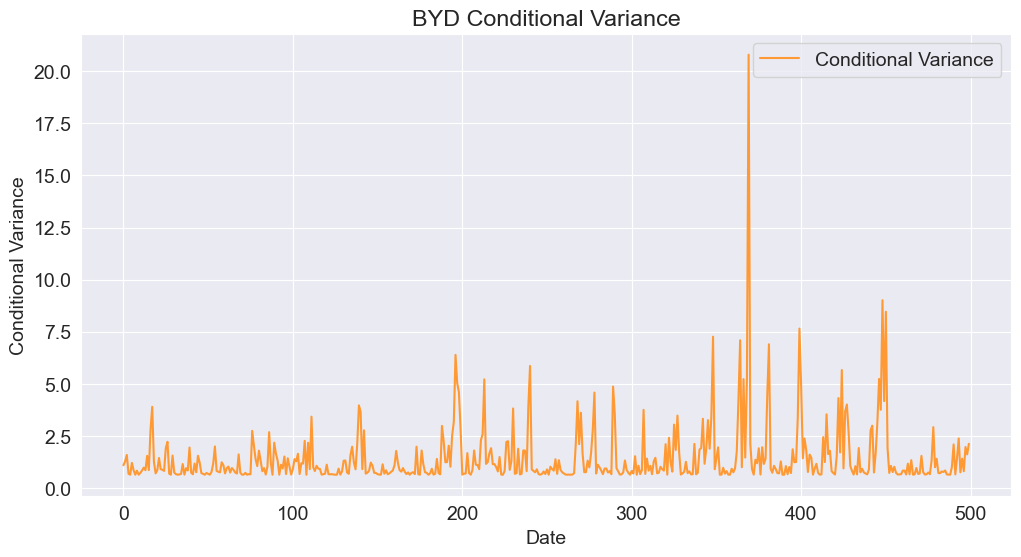

In [86]:
# Step 2: Extract conditional variance
conditional_variance = res.conditional_volatility ** 2  # Square to get variance

# Step 3: Plot conditional variance (similar to R's ggplot output)
plt.figure(figsize=(12,6))
plt.plot(df.index, conditional_variance, color='#ff9933', label='Conditional Variance')
plt.title('BYD Conditional Variance')
plt.xlabel('Date')
plt.ylabel('Conditional Variance')
plt.legend()
plt.show()

Looking at the graph, you can see the periods in which volatility was high.

## Specifying Common Models
The package in Python is very flexible and allows one to perform different estimations by just changing the code slightly. Most common specifications can be specified using a simple model constructor:

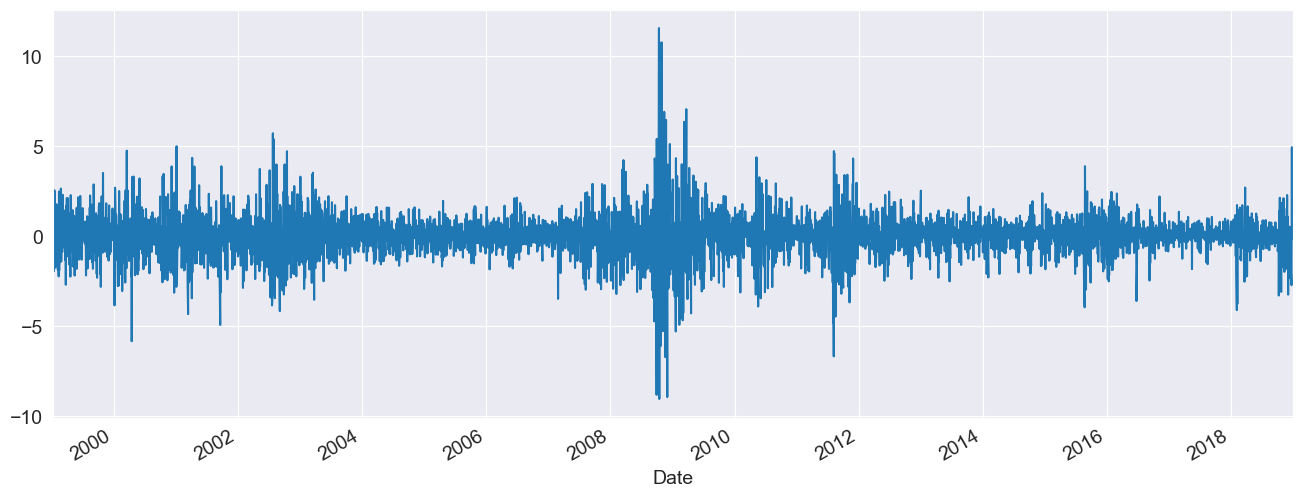

In [87]:
import datetime as dt
import arch.data.sp500

st = dt.datetime(1988, 1, 1)
en = dt.datetime(2018, 1, 1)
data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()
ax = returns.plot()
xlim = ax.set_xlim(returns.index.min(), returns.index.max())

The default set of options produces a model with a constant mean, GARCH(1,1) conditional variance and normal errors.

In [88]:
am = arch_model(returns)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11
                     Constant Mean - GARCH Model Results                      
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6936.72
Distribution:                  Normal   AIC:                           13881.4
Method:            Maximum Likelihood   BIC:                           13907.5
                                        No. Observations:                 5030
Date:                Wed, Feb 19 2025   Df Residuals:                     5029
Time:         

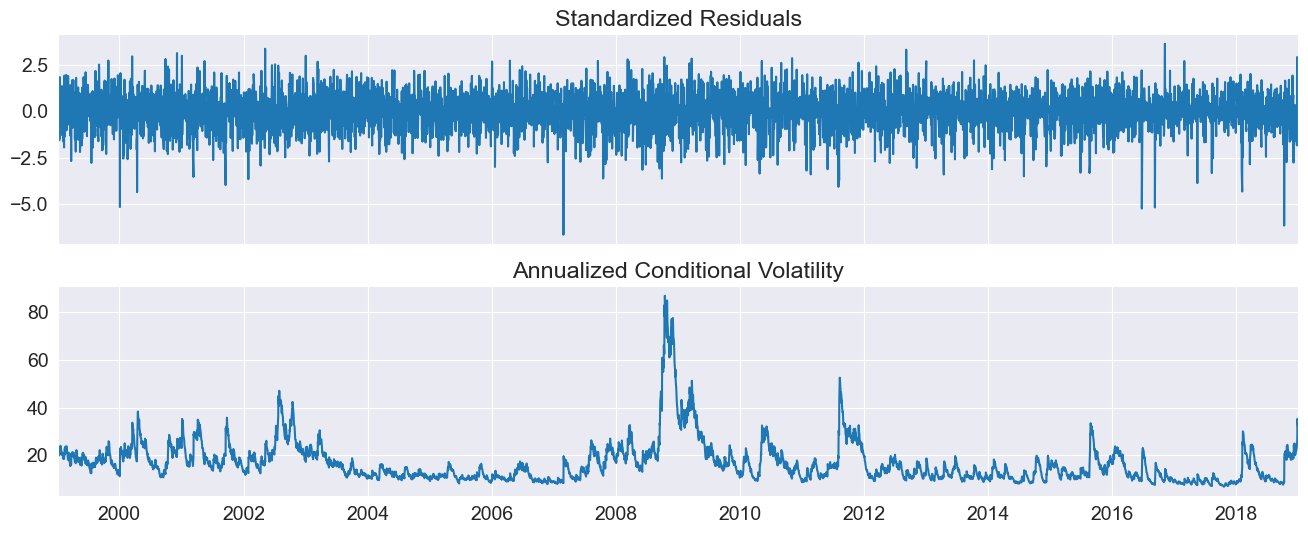

In [89]:
# plot() can be used to quickly visualize the standardized residuals and conditional volatility.
fig = res.plot(annualize="D")

### Extensions
Since the GARCH model was developed, a huge number of extensions and variants have been proposed. Three of the most important examples are EGARCH, GJR, and GARCH-M models.

#### EGARCH

In [92]:
#### EGARCH
am = arch_model(returns, vol = 'EGARCH')
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6957.03
Distribution:                  Normal   AIC:                           13922.1
Method:            Maximum Likelihood   BIC:                           13948.1
                                        No. Observations:                 5030
Date:                Wed, Feb 19 2025   Df Residuals:                     5029
Time:                        15:05:34   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0651  1.161e-02      5.606  2.070e-08 [4.

#### GJR-GARCH
Additional inputs can be used to construct other models. This example sets $o$ to 1, which includes one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics given by

$$
\sigma_t^2 = \omega + \alpha \epsilon_{t-1}^2 + \gamma \epsilon_{t-1}^2 \mathbf{I}_{[\epsilon_{t-1}<0>]} + \beta \sigma_{t-1}^2
$$

where $\mathbf{I}$ is an indicator function that takes the value 1 when its argument is true. In this example the log likelihood improves substantially with the introduction of an asymmetric term, and the parameter estimate is highly significant.

In [93]:
# GJR-GARCH
am = arch_model(returns, p=1, o=1, q=1)
res = am.fit(update_freq=5, disp="off")
print(res.summary())

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -6822.88
Distribution:                  Normal   AIC:                           13655.8
Method:            Maximum Likelihood   BIC:                           13688.4
                                        No. Observations:                 5030
Date:                Wed, Feb 19 2025   Df Residuals:                     5029
Time:                        15:08:34   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0175  1.145e-02      1.529      0.126 

## Forecasting Variances using GARCH Models
Producing conditional variance forecasts from GARCH models uses a very similar approach to producing forecasts from ARMA models. It is again an exercise in iterating with the conditional expectations operator.

Consider the following GARCH(1,1) model:
$$
y_t = \mu + u_t \, \, u_t ~ N(0, \sigma^2_t), \, \sigma_t^2 = \alpha_0 + \alpha_1 u_{t-1}^2 + \beta \sigma^2_{t-1}
$$

What is needed is to generate are forecasts of $\sigma^2_{T+1} | \Omega_T$, $\sigma^2_{T+2} | \Omega_T$, ..., $\sigma^2_{T+s} | \Omega_T$ where
$\Omega_T$ denotes all information available up to and including observation $T$.

Any s-step ahead forecast ($s\geq 2$) would be produced by:
$$
h^f_{s,T} = \alpha_0 \sum^{s-1}_{i=1}(\alpha_1 + \beta)^{i-1} + (\alpha_1 + \beta)^{s-1} h^f_{1,T}
$$

In [27]:
!pip install yfinance

     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     ---------------------------------------- 3.0/3.0 MB 60.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.9-py3-none-any.whl size=139096 sha256=d1a72ed3c63f840438fa4ede7ba2e8194c10c7ceceba92c7efac94314bdad5fc
  Stored in directory: c:\users\valte\appdata\local\pip\cache\wheels\43\ef\2d\2c51d496bf084945ffdf838b4cc8767b8ba1cc20eb41588831
Successfully built peewee



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Extracting Financial Data Directly into Python
One of the great advantages of Python for financial and econometric analysis is its ability to directly pull data from major financial data providers into your workflow. This eliminates the need to manually download datasets from websites and reformat them, making the process seamless, efficient, and reproducible.

[*********************100%***********************]  1 of 1 completed


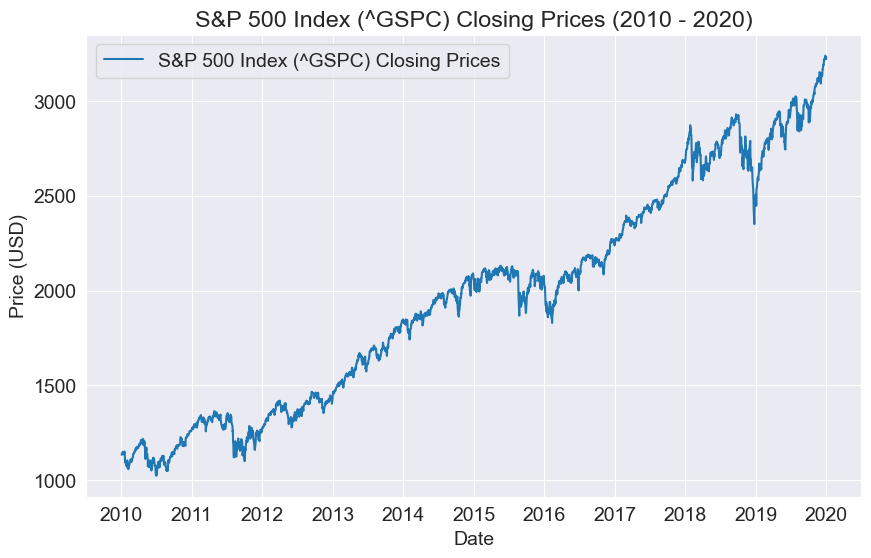

In [46]:
import yfinance as yf
import matplotlib.pyplot as plt

# Download historical data for S&P 500 (^GSPC)
sp500 = yf.download('^GSPC', start='2010-01-01', end='2020-01-01')

# Plot the closing prices
plt.figure(figsize=(10, 6))
plt.plot(sp500['Close'], label='S&P 500 Index (^GSPC) Closing Prices')
plt.title('S&P 500 Index (^GSPC) Closing Prices (2010 - 2020)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Besides Yahoo Finance, Python offers libraries to access a range of data sources:

1. pandas_datareader – Connects to multiple sources:
- FRED (Federal Reserve Economic Data) for macroeconomic indicators.
- World Bank for global development data.
- OECD for economic and social data.
- IEX Cloud for real-time and historical stock data.
- Tiingo for stocks, mutual funds, and crypto.

2. Quandl – Provides a wide range of financial, economic, and alternative datasets from various providers.

3. Alpha Vantage – Supplies real-time and historical stock, FX, and cryptocurrency data.

4. InvestPy – For retrieving data on stocks, ETFs, funds, and commodities from Investing.com.

This eliminates the need to download and upload CSV/Excel files. Also, scripts that pull and process data are easier to share and reproduce.

In [54]:
import datetime as dt
import yfinance as yf

# Define date range
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2014, 1, 1)

# Download data using yfinance
sp500 = yf.download('^GSPC', start=start, end=end)
# Calculate returns
sp500

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2000-01-03  1455.219971  1478.000000  1438.359985  1469.250000   931800000
2000-01-04  1399.420044  1455.219971  1397.430054  1455.219971  1009000000
2000-01-05  1402.109985  1413.270020  1377.680054  1399.420044  1085500000
2000-01-06  1403.449951  1411.900024  1392.099976  1402.109985  1092300000
2000-01-07  1441.469971  1441.469971  1400.729980  1403.449951  1225200000
...                 ...          ...          ...          ...         ...
2013-12-24  1833.319946  1833.319946  1828.020020  1828.020020  1307630000
2013-12-26  1842.020020  1842.839966  1834.959961  1834.959961  1982270000
2013-12-27  1841.400024  1844.890015  1839.810059  1842.969971  2052920000
2013-12-30  1841.069946  1842.469971  1838.770020  1841.469971  2293860000
2013-12-31  1848.359985  1849.439941  1842.410034  1842.609985  2312840000

[3521 rows x 5 columns]

In [56]:
# Calculate returns
returns = 100 * sp500['Close'].pct_change().dropna()
# Fit GARCH(1,1) model
am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')

# The model will be estimated using the first 10 years to estimate parameters and then forecasts will be produced for the final 5
split_date = dt.datetime(2010,1,1)
res = am.fit(last_obs=split_date)
res.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 4296849850.366523
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1097221636.3648314
Iteration:      3,   Func. Count:     22,   Neg. LLF: 3827.4582450947764
Iteration:      4,   Func. Count:     28,   Neg. LLF: 3803.5386646741604
Iteration:      5,   Func. Count:     34,   Neg. LLF: 3811.0761868660447
Iteration:      6,   Func. Count:     40,   Neg. LLF: 3850.925110749849
Iteration:      7,   Func. Count:     46,   Neg. LLF: 3787.3959126110403
Iteration:      8,   Func. Count:     52,   Neg. LLF: 3814.669673829536
Iteration:      9,   Func. Count:     58,   Neg. LLF: 3785.311520696806
Iteration:     10,   Func. Count:     64,   Neg. LLF: 3784.612420783653
Iteration:     11,   Func. Count:     70,   Neg. LLF: 3784.5844273541707
Iteration:     12,   Func. Count:     75,   Neg. LLF: 3784.5843806940425
Iteration:     13,   Func. Count:     79,   Neg. LLF: 3784.5843806937487
Optimization terminated successfully    (Exit mode 0)
  

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3784.58
Distribution:                  Normal   AIC:                           7577.17
Method:            Maximum Likelihood   BIC:                           7600.49
                                        No. Observations:                 2514
Date:                Thu, Feb 20 2025   Df Residuals:                     2513
Time:                        10:07:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0366  1.795e-02      2.036  4.177e-02 [1.361e-03,7.174e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0108  5.057e-03      2.129  3.323e-02 [8.564e-04,2.068e-02]
alpha[1]       0.0749  1.089e-02      6.884  5.835e-12 [5.360e-02,9.627e-02]
beta[1]        0.9183  1.122e-02     81.824      0.000     [  0.896,  0.940]
============================================================================

Covariance estimator: robust
"""

In [47]:
forecasts = res.forecast(horizon=5, start=split_date)
forecasts.variance[split_date:]

h.1       h.2       h.3       h.4       h.5
Date                                                        
2010-01-04  0.739303  0.745081  0.750819  0.756519  0.762181
2010-01-05  0.695349  0.701424  0.707457  0.713450  0.719402
2010-01-06  0.649343  0.655728  0.662070  0.668369  0.674625
2010-01-07  0.616975  0.623578  0.630137  0.636652  0.643123
2010-01-08  0.582090  0.588929  0.595722  0.602469  0.609171
...              ...       ...       ...       ...       ...
2013-12-24  0.489534  0.496998  0.504412  0.511775  0.519089
2013-12-26  0.474691  0.482255  0.489768  0.497231  0.504643
2013-12-27  0.447054  0.454805  0.462503  0.470150  0.477744
2013-12-30  0.421528  0.429451  0.437320  0.445137  0.452900
2013-12-31  0.407544  0.415561  0.423525  0.431434  0.439290

[1006 rows x 5 columns]

In [42]:
print(forecasts.variance.tail())

                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2013-12-24  0.489534  0.496998  0.504412  0.511775  0.519089
2013-12-26  0.474691  0.482255  0.489768  0.497231  0.504643
2013-12-27  0.447054  0.454805  0.462503  0.470150  0.477744
2013-12-30  0.421528  0.429451  0.437320  0.445137  0.452900
2013-12-31  0.407544  0.415561  0.423525  0.431434  0.439290


The values in the columns h.1 are one-step ahead forecast, while values in h.2, …, h.5 are 2, …, 5-observation ahead forecasts. The output is aligned so that the Date column is the final data used to generate the forecast, so that h.1 in row 2013-12-31 is the one-step ahead forecast made using data up to and including December 31, 2013.

```python
ARCHModelResult.forecast(
    params: ndarray | Series | None = None, 
    horizon: int = 1, 
    start: int | str | datetime | datetime64 | Timestamp | None = None, 
    align: 'origin' | 'target' = 'origin', 
    method: 'analytic' | 'simulation' | 'bootstrap' = 'analytic', 
    simulations: int = 1000, 
    rng: Callable[[int | tuple[int, ...]], ndarray[Any, dtype[float64]]] | None = None, 
    random_state: RandomState | None = None, *, 
    reindex: bool = False, 
    x: dict[Hashable | None, ndarray | DataFrame | Series] | ndarray | DataFrame | Series | None = None) → ARCHModelForecast
```

Any call to forecast() returns a ARCHModelForecast object with has 3 core attributes and 1 which may be useful when using simulation- or bootstrap-based forecasts. The three core atttributes are:
- **mean**: The forecast conditional mean
- **variance**: The forecast conditional variance.
- **residual_variance**:The forecast conditional variance of residuals. This will differ from variance whenever the model has dynamics (e.g. an AR model) for horizons larger than 1.

In [78]:
import numpy as np
import numba
import time

# Define matrix size
N = 500

# Create two large random matrices
A = np.random.rand(N, N)
B = np.random.rand(N, N)

# 1️⃣ NumPy Version (Using np.dot)
def numpy_dot(A, B):
    return np.dot(A, B)

# 2️⃣ Numba Version (Using nested for-loops)
@numba.jit(nopython=True)
def numba_dot(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return result

def pure_python_dot(A, B):
    N = len(A)
    result = [[0.0] * N for _ in range(N)]
    for i in range(N):
        for j in range(N):
            for k in range(N):
                result[i][j] += A[i][k] * B[k][j]
    return result


# # ⚡ Timing NumPy Version
# start_time = time.time()
# numpy_result = numpy_dot(A, B)
# numpy_time = time.time() - start_time
# print(f"NumPy dot product Time: {numpy_time:.5f} seconds")

# ⚡ Timing Numba Version
start_time = time.time()
numba_result = numba_dot(A, B)
numba_time = time.time() - start_time
print(f"Numba dot product Time: {numba_time:.5f} seconds")


# Convert numpy arrays to lists for pure Python function
A_list = A.tolist()
B_list = B.tolist()

# ⚡ Timing Pure Python Version
start_time = time.time()
pure_python_result = pure_python_dot(A_list, B_list)
pure_python_time = time.time() - start_time
print(f"Pure Python dot product Time: {pure_python_time:.5f} seconds")

# 🔥 Speed-up Factor
print(f"Numba is {pure_python_time / numba_time:.2f}x faster than pure Python loops")

Numba dot product Time: 0.19357 seconds
Pure Python dot product Time: 12.60091 seconds
Numba is 65.10x faster than pure Python loops
